# Loads in the dataframes

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
%matplotlib inline

# loads the dataframes
semi_leptonic_df = pd.read_hdf(
    "/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/TTToSemiLeptonic/df_ml_inputs.hd5"
)
higgs_df = pd.read_hdf(
    "/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/ttH125/df_ml_inputs.hd5"
)

# labels signal vs background
semi_leptonic_df["signal"] = 0
higgs_df["signal"] = 1

# combines the dataframes and randomly shuffles the rows
full_df = semi_leptonic_df.append(higgs_df, ignore_index=True)
full_df = shuffle(full_df)

In [ ]:
event_cols = [
    "BiasedDPhi",
    "DiJet_mass",
    "HT",
    "InputMet_InputJet_mindPhi",
    "InputMet_pt",
    "MHT_pt",
    "MinChi",
    "MinOmegaHat",
    "MinOmegaTilde",
    "ncleanedBJet",
    "ncleanedJet",
]

object_cols = [
    "cleanedJet_pt",
    "cleanedJet_area",
    "cleanedJet_btagDeepB",
    "cleanedJet_chHEF",
    "cleanedJet_eta",
    "cleanedJet_mass",
    "cleanedJet_neHEF",
    "cleanedJet_phi",
]

df = full_df[event_cols + object_cols + ["signal"]]

# Splits data into event / object dataframes and train / test dataframes

In [5]:
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence

scaler = StandardScaler()

# columns that should not be transformed
untransformed_cols = ["ncleanedBJet", "ncleanedJet", "BiasedDPhi", "signal"]
transformed_cols = list(set(event_cols) - set(untransformed_cols))

# takes the log of each column to remove skewness
for col_name in event_cols:
    if col_name in transformed_cols:
        df[col_name] = np.log(df[col_name])

# splits data into training and validation
X, y = df.drop("signal", axis=1), df["signal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# divides training data into object level and event level features
event_X_train, event_X_test = X_train[event_cols], X_test[event_cols]
object_X_train, object_X_test = X_train[object_cols], X_test[object_cols]

# scales features so they all have the same mean and variance
event_X_train[event_cols] = scaler.fit_transform(event_X_train[event_cols].values)
event_X_test[event_cols] = scaler.transform(event_X_test[event_cols].values)

max_jets = df["ncleanedJet"].max()

# pads input sequences with zeroes so they're all the same length
for col in object_cols:
    object_X_train[col] = sequence.pad_sequences(
        object_X_train[col].values, padding="post", dtype="float32"
    ).tolist()
    object_X_test[col] = sequence.pad_sequences(
        object_X_test[col].values, padding="post", dtype="float32"
    ).tolist()

print(
    "Removed Columns:",
    [col for col in full_df.columns if col not in set(event_cols + object_cols)],
)
X_train.head()

Removed Columns: ['dataset', 'entry', 'InputMet_phi', 'MHT_phi', 'hashed_filename', 'weight_nominal', 'xs_weight', 'signal']


,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,cleanedJet_pt,cleanedJet_area,cleanedJet_btagDeepB,cleanedJet_chHEF,cleanedJet_eta,cleanedJet_mass,cleanedJet_neHEF,cleanedJet_phi
393841,-2.954528,4.835722,6.244332,0.543300,6.036079,5.993762,0.377000,0.070807,-0.350449,0,5,"[217.68346, 124.40049, 88.6081, 45.38404, 39.0...","[0.5185547, 0.50878906, 0.4987793, 0.47875977,...","[0.04486084, 0.12854004, 0.0099487305, 0.24951...","[0.765625, 0.71875, 0.734375, 0.578125, 0.6875]","[-2.3880033, -1.6439531, -1.9750642, -1.413401...","[19.671875, 13.859375, 14.3984375, 11.09375, 8...","[0.0126953125, 0.01184082, 0.13867188, 0.0, 0....","[0.5032827854156494, 0.45880717039108276, -0.3..."
227734,-2.918790,6.458021,6.282947,0.547263,5.370638,5.464726,-0.546644,-0.546642,-0.546644,2,5,"[187.2579, 140.48297, 91.36589, 74.17178, 42.0...","[0.5185547, 0.5185547, 0.48876953, 0.4189453, ...","[0.21228027, 0.09161377, 0.62939453, 0.1229248...","[0.609375, 0.8203125, 0.1484375, 0.140625, 0.3...","[-1.046316, 2.450548, 2.3086433, 2.525471, -0....","[16.4375, 25.03125, 13.953125, 9.09375, 7.421875]","[0.0, 0.02319336, 0.30859375, 0.3515625, 0.205...","[-1.1482970714569092, -0.3035745620727539, 0.2..."
84230,-2.314572,5.709746,6.513491,0.483703,5.575949,5.543724,-0.047976,-0.159282,-1.091589,0,7,"[223.31854, 156.76071, 91.369, 69.11581, 53.46...","[0.5185547, 0.50878906, 0.5288086, 0.5185547, ...","[0.03933716, 0.07763672, 0.010070801, 0.348388...","[0.59375, 0.6953125, 0.703125, 0.6328125, 0.89...","[0.119160354, 0.88841516, -0.23663731, -1.7487...","[34.28125, 23.953125, 11.4609375, 12.6015625, ...","[0.115234375, 0.10644531, 0.080078125, 0.01489...","[0.7634888291358948, 0.11453670263290405, -0.1..."
189850,-1.994270,5.447066,6.401299,-0.545435,5.313206,5.353164,-0.345204,-0.345204,-0.345204,0,5,"[142.71065, 136.1303, 135.73561, 130.29855, 57...","[0.48876953, 0.5185547, 0.46875, 0.48876953, 0...","[0.061920166, 0.14929199, 0.36376953, 0.341064...","[0.28515625, 0.6484375, 0.07519531, 0.33203125...","[0.77471244, -0.4997542, 2.310719, -1.2498467,...","[20.59375, 21.4375, 10.875, 13.78125, 9.0078125]","[0.32421875, 0.029296875, 0.13867188, 0.014892...","[-0.38757389783859253, -0.8685798645019531, -0..."
19673,-2.942374,4.178560,5.606143,1.078224,5.440793,5.601884,0.451583,-0.034801,-0.856210,1,2,"[187.35246, 84.740395]","[0.5288086, 0.40893555]","[0.99658203, 0.13879395]","[0.7734375, 0.671875]","[-1.8998004, -1.4238498]","[18.890625, 12.390625]","[0.0071411133, 0.030517578]","[-0.41457676887512207, -0.6102555990219116]"


# Expands the lists in the df so they can be used as input

In [6]:
temp_X_train = np.ndarray(
    shape=(object_X_train.shape[0], max_jets, len(object_X_train.columns))
)
temp_X_test = np.ndarray(
    shape=(object_X_test.shape[0], max_jets, len(object_X_test.columns))
)

# iterate through each column in the df and iterate through each value in the column and then iterate through each item in the list and then put that item in the nparray
for i, col in enumerate(object_cols):
    train_col = object_X_train[col]
    test_col = object_X_test[col]

    for j, event in enumerate(train_col):
        for k, item in enumerate(event):
            temp_X_train[j][k][i] = item

    for j, event in enumerate(test_col):
        for k, item in enumerate(event):
            temp_X_test[j][k][i] = item

object_X_train = temp_X_train
object_X_test = temp_X_test

# Scales the data

In [7]:
from sklearn.preprocessing import RobustScaler

nz = np.any(object_X_train, -1)
object_X_train[nz] = RobustScaler().fit_transform(object_X_train[nz])
nz = np.any(object_X_test, -1)
object_X_test[nz] = RobustScaler().fit_transform(object_X_test[nz])

# Plots the jet positions as a scatter plot to visualize the transformations

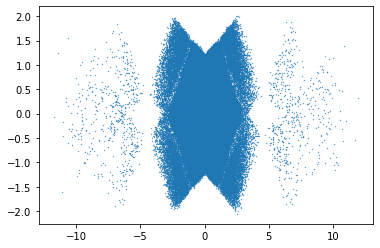

In [8]:
import matplotlib.pyplot as plt
from numpy.random import randint

i = randint(0, object_X_train.shape[0])
# eta, phi
plt.scatter(object_X_train[:, :, 7], object_X_train[:, :, 4], s=0.1)

# Hyperparameters

In [9]:
# binary classifier neural network
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from sklearn.utils import class_weight


def f1_score(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


# sets hyperparameters
learning_rate_init = 0.0005
activation = "relu"
batch_size = 64
epochs = 10  # 70
patience = 5
loss = "binary_crossentropy"
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8

optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate_init,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)

METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="AUC"),
    f1_score,
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="f1_score",
    verbose=1,
    patience=patience,
    mode="max",
    restore_best_weights=True,
)

# weighting the classes lowers accuracy and precision but increases recall and f1 score
# class_weights = [1/float(full_df['xs_weight'].loc[full_df['signal'] == _class].mode()) for _class in np.unique(y_train)]
# class_weights = [i / min(class_weights) for i in class_weights]
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = {l: c for l, c in zip(np.unique(y_train), class_weights)}
print(class_weights)

# saves the network at regular intervals so you can pick the best version
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/tmp/checkpoint",
    monitor="f1_score",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
)

{0: 0.6676178944857293, 1: 1.9914875333986761}


2021-11-24 21:11:06.372941: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-24 21:11:06.373468: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-24 21:11:06.375205: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Defines and compiles the model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Concatenate
from keras import Model

DNN_model = Sequential(
    [
        Dense(100, input_shape=(len(event_cols),), activation=activation),
        Dropout(0.2),
    ]
)

RNN_model = Sequential(
    [
        LSTM(
            100,
            input_shape=(max_jets, len(object_cols)),
            activation="tanh",
            unroll=False,
            dropout=0.2,
            recurrent_dropout=0.2,
            return_sequences=True,
        ),
        LSTM(
            100, 
            activation='tanh',
            unroll=False,
            dropout=0.2, 
            recurrent_dropout=0.2),
    ]
)

merged = Concatenate()([DNN_model.output, RNN_model.output])
z = Dense(200, activation=activation)(merged)
z = Dropout(0.2)(z)
z = Dense(100, activation=activation)(z)
z = Dense(100, activation=activation)(z)
z = Dense(100, activation=activation)(z)
z = Dense(100, activation=activation)(z)
z = Dense(100, activation=activation)(z)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[DNN_model.input, RNN_model.input], outputs=z)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 11)]         0                                            
__________________________________________________________________________________________________
lstm_input (InputLayer)         [(None, 14, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          1200        dense_input[0][0]                
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 14, 100)      43600       lstm_input[0][0]                 
______________________________________________________________________________________________

# Trains the model

In [11]:
model.fit(
    [event_X_train, object_X_train],
    y_train,
    batch_size=batch_size,
    class_weight=class_weights,
    epochs=3,
    callbacks=[early_stopping],
    validation_data=([event_X_test, object_X_test], y_test),
    verbose=1,
)

2021-11-24 21:11:07.869339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-24 21:11:07.881521: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394015000 Hz


Epoch 1/3
4636/4636 [==============================] - 9309s 2s/step - loss: 0.5442 - accuracy: 0.7237 - precision: 0.4676 - recall: 0.7342 - AUC: 0.7989 - f1_score: 0.5654 - val_loss: 0.5235 - val_accuracy: 0.7324 - val_precision: 0.4793 - val_recall: 0.7640 - val_AUC: 0.8211 - val_f1_score: 0.5826
Epoch 2/3
1615/4636 [=========>....................] - ETA: 1:30:58 - loss: 0.5234 - accuracy: 0.7444 - precision: 0.4925 - recall: 0.7358 - AUC: 0.8167 - f1_score: 0.5838